In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader # loads data in batches
from torchvision import datasets # load MNIST
import torchvision.transforms as T # transformers for computer vision
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [2]:
# test = torch.Tensor([[0.5, -1.0, -1.8, 1.2, 2.0],
#                     [-1.4, 0.4, 0.6, 1.3, -1.6]])
# synapse_weight = np.load('Synapse_weight/weight1.npy')

# for param in test:
#     param_shape = param.shape
#     param = param.view(-1)
#     for i in range(len(param)):
#         w_index = np.argmin(np.abs(param[i].item() - synapse_weight))
#         print(w_index)
#         param[i] = synapse_weight[w_index]
#     param.reshape(param_shape)

# for i, param in enumerate(test):
#     param_shape = param.shape
#     param_clone = torch.clone(param).cpu()
#     w_index = np.argmin(np.abs(param_clone.numpy().reshape(-1, 1) - np.tile(np.array(synapse_weight).reshape(1, -1), (param_clone.numpy().size, 1))), axis=1)
#     param[...] = torch.Tensor(synapse_weight[w_index]).view(param_shape)
#     # test[i] = param.view(param_shape)

# print(test)
# print(synapse_weight)

# Data processing

In [3]:
totensor = T.ToTensor() # image (3D array) to Tensor

train_data = datasets.MNIST(root = './', download=False, train = True, transform = totensor)
test_data = datasets.MNIST(root = './', download=False, train = False, transform = totensor)

In [4]:
img, label = train_data[0]
print(img.shape) # returns a Tensor of Size 1,28,28
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


In [5]:
# 只取 0, 1, 2 作為資料集
print(len(train_data))
new_train_img = []
new_train_label = []
for i in range(len(train_data)):
    img, label = train_data[i]
    if label == 0 or label == 1 or label == 2:
        new_train_img.append(img.numpy())
        new_train_label.append(label)
print(len(new_train_img))

print(len(test_data))
new_test_img = []
new_test_label = []
for i in range(len(test_data)):
    img, label = test_data[i]
    if label == 0 or label == 1 or label == 2:
        new_test_img.append(img.numpy())
        new_test_label.append(label)
        
print(len(new_test_img))

60000
18623
10000
3147


In [6]:
new_train_img, new_train_label = np.array(new_train_img), np.array(new_train_label)
new_test_img, new_test_label = np.array(new_test_img), np.array(new_test_label)
print(new_train_img.shape, new_train_label.shape)
print(new_test_img.shape, new_test_label.shape)

(18623, 1, 28, 28) (18623,)
(3147, 1, 28, 28) (3147,)


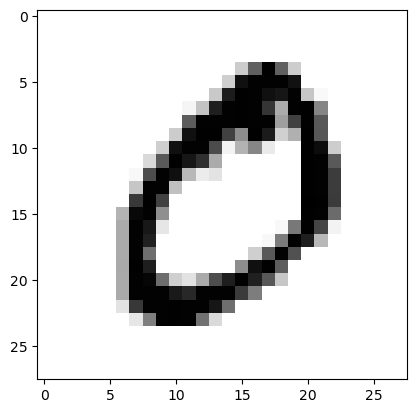

In [7]:
plt.imshow(new_train_img[0].reshape(28,28), cmap = 'gist_yarg'); # gist_yarg plots inverse of W&B

In [8]:
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass

class MNIST_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

torch.manual_seed(101)

train_loader = DataLoader(MNIST_Dataset(new_train_img, new_train_label), batch_size=100, shuffle=True)
test_loader =  DataLoader(MNIST_Dataset(new_test_img, new_test_label),  batch_size=500, shuffle=False)

@dataclass
class Loader:
    """
    Custom class to accomodate train and test loader iterators
    If we run one iteration now, we will have one batch of the training dataset
    """
    train: DataLoader
    test: DataLoader

mnist_loader = Loader(train_loader, test_loader)
for img, label in mnist_loader.train:
    break # we run only one iteration , after that we break
print(img.shape) # bz, ch, W H
print(mnist_loader.train)

torch.Size([100, 1, 28, 28])


# Build model

In [9]:
class ThreeLayerANN(nn.Module):
    
    def __init__(self, in_size = 784, out_size=3):
        """
        * 784 input layers 
        * 2 hiden layers of 3 and 3 neurons respectively
        * 3 output layer
        """
        super(ThreeLayerANN, self).__init__()
        
        self.layer1 = nn.Linear(in_size, 3)
        self.layer2 = nn.Linear(3, 3)
        self.layer3 = nn.Linear(3, out_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim = 1)
            
    def forward(self, X):

        X = self.sigmoid(self.layer1(X))
        X = self.sigmoid(self.layer2(X))
        X = self.layer3(X)
        
        return self.softmax(X) # multi-class classification, the sum of all probabilities is 1

model = ThreeLayerANN().cuda()
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]           2,355
           Sigmoid-2                 [-1, 1, 3]               0
            Linear-3                 [-1, 1, 3]              12
           Sigmoid-4                 [-1, 1, 3]               0
            Linear-5                 [-1, 1, 3]              12
           Softmax-6                 [-1, 1, 3]               0
Total params: 2,379
Trainable params: 2,379
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# Train

In [10]:
def train_model(model, loader, criterion, optimizer, scheduler, epochs=50, synapse=False):
    """
    synapse : bool, default=False. 若synapse=True則限制權重於給定的檔案
    """
    synapse_weight = np.load('Synapse_weight/weight1.npy')
    Loss = {'train':[], 'test':[]}
    Accuracy = {'train':[], 'test':[]}
    model = model.cuda()

    for epoch in tqdm(range(epochs)):
        # we set the number of True positives to zero in every epoch
        train_corr = 0
        test_corr = 0
        train_size = 0
        test_size = 0
        
        ##### Training loop #####
        model.train()
        for batch, (img, label) in enumerate(loader.train): 
            batch +=1
            train_size += len(img)
            img = img.cuda()
            label = label.cuda()
            y_pred = model(img.view(img.shape[0],-1)) # batch size for train is 100
            loss = criterion(y_pred, label)
            
            # last 3-layer neurons into one result
            _, prediction = torch.max(y_pred, dim=1) # return (values, indices)
            train_corr += (prediction == label).sum() # sum of correct predictions

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if synapse:
                ##### 限制權重範圍 #####
                for p in model.parameters():
                    p.data.clamp_(-2, 2)
                #######################

                ##### 限制權重的值 #####
                with torch.no_grad():
                    for i, param in enumerate(model.parameters()):
                        param_shape = param.shape
                        param_clone = torch.clone(param).cpu()
                        w_index = np.argmin(np.abs(param_clone.numpy().reshape(-1, 1) - np.tile(np.array(synapse_weight).reshape(1, -1), (param_clone.numpy().size, 1))), axis=1)
                        param[...] = torch.Tensor(synapse_weight[w_index]).view(param_shape)
                #######################
        
        # scheduler.step(loss)
        
        accuracy = 100 * (train_corr.item() / train_size ) 
        print( f'Epoch:{epoch+1:2d} Train Loss: {loss.item():4.4f} Train Accuracy: {accuracy:4.4f} %' )

        Loss['train'].append(loss.item()) # store loss at the end of epoch
        Accuracy['train'].append(accuracy) # store accuracy at the end of epoch

        ##### Validation loop #####
        model.eval()
        # validation (test). Here we run batches of 500 images, the test loader runs 120 times (120 x 500 = 60,000)
        with torch.no_grad():
            for batch, (img, label) in enumerate(loader.test):
                batch +=1
                test_size += len(img)
                img = img.cuda()
                label = label.cuda()
                y_val = model(img.view(img.shape[0],-1)) # batch size for test is 500
                _, predicted = torch.max(y_val, dim = 1)
                test_corr += (predicted == label).sum()
        
        loss = criterion(y_val, label)
        Loss['test'].append(loss.item()) 
        accuracy = 100 * (test_corr.item() / test_size)
        print( f'Test Accuracy: {accuracy:4.4f} %' )
        Accuracy['test'].append(accuracy)
    
    return model, Loss, Accuracy

In [11]:
# case0 training (all ideal)
model_case0 = ThreeLayerANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case0.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True, min_lr=1e-6)
model0, Loss0, Accuracy0 = train_model(model=model_case0, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=50, synapse=False)

best_acc = np.max(Accuracy0['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')

  2%|▏         | 1/50 [00:00<00:23,  2.12it/s]

Epoch: 1 Train Loss: 0.8146 Train Accuracy: 66.1923 %
Test Accuracy: 67.0162 %


  4%|▍         | 2/50 [00:00<00:22,  2.17it/s]

Epoch: 2 Train Loss: 0.8230 Train Accuracy: 67.8247 %
Test Accuracy: 66.9844 %


  6%|▌         | 3/50 [00:01<00:21,  2.17it/s]

Epoch: 3 Train Loss: 0.7657 Train Accuracy: 67.7442 %
Test Accuracy: 68.5097 %


  8%|▊         | 4/50 [00:01<00:21,  2.17it/s]

Epoch: 4 Train Loss: 0.8194 Train Accuracy: 67.6744 %
Test Accuracy: 66.9527 %


 10%|█         | 5/50 [00:02<00:20,  2.18it/s]

Epoch: 5 Train Loss: 0.8251 Train Accuracy: 67.9053 %
Test Accuracy: 66.8891 %


 12%|█▏        | 6/50 [00:02<00:20,  2.17it/s]

Epoch: 6 Train Loss: 0.6016 Train Accuracy: 79.6649 %
Test Accuracy: 98.5383 %


 14%|█▍        | 7/50 [00:03<00:19,  2.18it/s]

Epoch: 7 Train Loss: 0.6078 Train Accuracy: 98.6522 %
Test Accuracy: 98.7925 %


 16%|█▌        | 8/50 [00:03<00:19,  2.18it/s]

Epoch: 8 Train Loss: 0.5610 Train Accuracy: 98.6522 %
Test Accuracy: 99.0785 %


 18%|█▊        | 9/50 [00:04<00:18,  2.19it/s]

Epoch: 9 Train Loss: 0.5576 Train Accuracy: 98.8777 %
Test Accuracy: 99.0467 %


 20%|██        | 10/50 [00:04<00:18,  2.19it/s]

Epoch:10 Train Loss: 0.5558 Train Accuracy: 99.0281 %
Test Accuracy: 98.9196 %


 22%|██▏       | 11/50 [00:05<00:18,  2.13it/s]

Epoch:11 Train Loss: 0.5550 Train Accuracy: 98.9851 %
Test Accuracy: 99.0149 %


 24%|██▍       | 12/50 [00:05<00:17,  2.14it/s]

Epoch:12 Train Loss: 0.5542 Train Accuracy: 98.9583 %
Test Accuracy: 99.2374 %


 26%|██▌       | 13/50 [00:06<00:17,  2.15it/s]

Epoch:13 Train Loss: 0.5539 Train Accuracy: 99.0818 %
Test Accuracy: 99.2056 %


 28%|██▊       | 14/50 [00:06<00:16,  2.16it/s]

Epoch:14 Train Loss: 0.5961 Train Accuracy: 99.0764 %
Test Accuracy: 99.0467 %


 30%|███       | 15/50 [00:07<00:19,  1.84it/s]

Epoch:15 Train Loss: 0.5531 Train Accuracy: 99.1462 %
Test Accuracy: 99.0785 %


 32%|███▏      | 16/50 [00:08<00:23,  1.46it/s]

Epoch:16 Train Loss: 0.5527 Train Accuracy: 99.1570 %
Test Accuracy: 99.1420 %


 34%|███▍      | 17/50 [00:08<00:20,  1.60it/s]

Epoch:17 Train Loss: 0.5528 Train Accuracy: 99.1516 %
Test Accuracy: 99.2374 %


 36%|███▌      | 18/50 [00:09<00:18,  1.74it/s]

Epoch:18 Train Loss: 0.5526 Train Accuracy: 99.1945 %
Test Accuracy: 99.2056 %


 38%|███▊      | 19/50 [00:09<00:16,  1.86it/s]

Epoch:19 Train Loss: 0.5523 Train Accuracy: 99.1999 %
Test Accuracy: 99.1738 %


 40%|████      | 20/50 [00:10<00:15,  1.94it/s]

Epoch:20 Train Loss: 0.5522 Train Accuracy: 99.1355 %
Test Accuracy: 98.9514 %


 42%|████▏     | 21/50 [00:10<00:14,  2.01it/s]

Epoch:21 Train Loss: 0.5523 Train Accuracy: 99.3180 %
Test Accuracy: 99.0785 %


 44%|████▍     | 22/50 [00:10<00:13,  2.07it/s]

Epoch:22 Train Loss: 0.5520 Train Accuracy: 99.2375 %
Test Accuracy: 99.2374 %


 46%|████▌     | 23/50 [00:11<00:15,  1.78it/s]

Epoch:23 Train Loss: 0.5954 Train Accuracy: 99.3180 %
Test Accuracy: 98.9832 %


 48%|████▊     | 24/50 [00:12<00:19,  1.36it/s]

Epoch:24 Train Loss: 0.5520 Train Accuracy: 99.3073 %
Test Accuracy: 99.0785 %


 50%|█████     | 25/50 [00:13<00:17,  1.46it/s]

Epoch:25 Train Loss: 0.5519 Train Accuracy: 99.1086 %
Test Accuracy: 99.1103 %


 52%|█████▏    | 26/50 [00:13<00:15,  1.59it/s]

Epoch:26 Train Loss: 0.5518 Train Accuracy: 99.2214 %
Test Accuracy: 99.0785 %


 54%|█████▍    | 27/50 [00:14<00:13,  1.69it/s]

Epoch:27 Train Loss: 0.5518 Train Accuracy: 99.2536 %
Test Accuracy: 99.2056 %


 56%|█████▌    | 28/50 [00:14<00:12,  1.81it/s]

Epoch:28 Train Loss: 0.5517 Train Accuracy: 99.3127 %
Test Accuracy: 99.2056 %


 58%|█████▊    | 29/50 [00:15<00:11,  1.91it/s]

Epoch:29 Train Loss: 0.5517 Train Accuracy: 99.3342 %
Test Accuracy: 98.9196 %


 60%|██████    | 30/50 [00:15<00:10,  1.98it/s]

Epoch:30 Train Loss: 0.5517 Train Accuracy: 99.1999 %
Test Accuracy: 99.1738 %


 62%|██████▏   | 31/50 [00:16<00:11,  1.59it/s]

Epoch:31 Train Loss: 0.5951 Train Accuracy: 99.2858 %
Test Accuracy: 99.2056 %


 64%|██████▍   | 32/50 [00:17<00:12,  1.46it/s]

Epoch:32 Train Loss: 0.5516 Train Accuracy: 99.1570 %
Test Accuracy: 98.9196 %


 66%|██████▌   | 33/50 [00:18<00:10,  1.62it/s]

Epoch:33 Train Loss: 0.5519 Train Accuracy: 99.2697 %
Test Accuracy: 99.1738 %


 68%|██████▊   | 34/50 [00:18<00:09,  1.75it/s]

Epoch:34 Train Loss: 0.5516 Train Accuracy: 99.3180 %
Test Accuracy: 99.2056 %


 70%|███████   | 35/50 [00:18<00:08,  1.86it/s]

Epoch:35 Train Loss: 0.5516 Train Accuracy: 99.2429 %
Test Accuracy: 99.0149 %


 72%|███████▏  | 36/50 [00:19<00:07,  1.92it/s]

Epoch:36 Train Loss: 0.5516 Train Accuracy: 99.3717 %
Test Accuracy: 99.1420 %


 74%|███████▍  | 37/50 [00:19<00:06,  1.99it/s]

Epoch:37 Train Loss: 0.5516 Train Accuracy: 99.3288 %
Test Accuracy: 99.1420 %


 76%|███████▌  | 38/50 [00:20<00:05,  2.03it/s]

Epoch:38 Train Loss: 0.5950 Train Accuracy: 99.3556 %
Test Accuracy: 99.1738 %


 78%|███████▊  | 39/50 [00:21<00:06,  1.72it/s]

Epoch:39 Train Loss: 0.5580 Train Accuracy: 99.1516 %
Test Accuracy: 99.0467 %


 80%|████████  | 40/50 [00:22<00:06,  1.45it/s]

Epoch:40 Train Loss: 0.5515 Train Accuracy: 99.1462 %
Test Accuracy: 99.0149 %


 82%|████████▏ | 41/50 [00:22<00:05,  1.61it/s]

Epoch:41 Train Loss: 0.5515 Train Accuracy: 99.2912 %
Test Accuracy: 98.9832 %


 84%|████████▍ | 42/50 [00:22<00:04,  1.75it/s]

Epoch:42 Train Loss: 0.5515 Train Accuracy: 99.3449 %
Test Accuracy: 99.0785 %


 86%|████████▌ | 43/50 [00:23<00:03,  1.86it/s]

Epoch:43 Train Loss: 0.5515 Train Accuracy: 99.2644 %
Test Accuracy: 98.3159 %


 88%|████████▊ | 44/50 [00:24<00:04,  1.50it/s]

Epoch:44 Train Loss: 0.5515 Train Accuracy: 99.0979 %
Test Accuracy: 99.1103 %


 90%|█████████ | 45/50 [00:25<00:03,  1.38it/s]

Epoch:45 Train Loss: 0.5515 Train Accuracy: 99.2214 %
Test Accuracy: 99.0467 %


 92%|█████████▏| 46/50 [00:25<00:02,  1.56it/s]

Epoch:46 Train Loss: 0.5515 Train Accuracy: 99.2536 %
Test Accuracy: 99.0467 %


 94%|█████████▍| 47/50 [00:26<00:01,  1.71it/s]

Epoch:47 Train Loss: 0.5515 Train Accuracy: 99.2160 %
Test Accuracy: 99.2056 %


 96%|█████████▌| 48/50 [00:26<00:01,  1.79it/s]

Epoch:48 Train Loss: 0.5950 Train Accuracy: 99.3717 %
Test Accuracy: 99.1738 %


 98%|█████████▊| 49/50 [00:27<00:00,  1.44it/s]

Epoch:49 Train Loss: 0.5515 Train Accuracy: 99.2751 %
Test Accuracy: 99.1738 %


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]

Epoch:50 Train Loss: 0.5515 Train Accuracy: 99.2751 %
Test Accuracy: 99.2056 %
----------------------------------------------------
Best Test Accuracy: 99.2374 %


In [12]:
# case2 training (ideal activation function / extracted synapse weight)
model_case2 = ThreeLayerANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_case0.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True, min_lr=1e-6)
model2, Loss2, Accuracy2 = train_model(model=model_case0, loader=mnist_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=50, synapse=True)

best_acc = np.max(Accuracy2['test'])
print('----------------------------------------------------')
print(f'Best Test Accuracy: {best_acc:4.4f} %')

  2%|▏         | 1/50 [00:00<00:39,  1.24it/s]

Epoch: 1 Train Loss: 0.8057 Train Accuracy: 68.0342 %
Test Accuracy: 67.0480 %


  4%|▍         | 2/50 [00:01<00:48,  1.01s/it]

Epoch: 2 Train Loss: 0.8038 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


  6%|▌         | 3/50 [00:03<00:52,  1.11s/it]

Epoch: 3 Train Loss: 0.8440 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


  8%|▊         | 4/50 [00:03<00:44,  1.02it/s]

Epoch: 4 Train Loss: 0.8454 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 10%|█         | 5/50 [00:05<00:49,  1.10s/it]

Epoch: 5 Train Loss: 0.8454 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 12%|█▏        | 6/50 [00:06<00:50,  1.14s/it]

Epoch: 6 Train Loss: 0.7679 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 14%|█▍        | 7/50 [00:07<00:45,  1.06s/it]

Epoch: 7 Train Loss: 0.8839 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 16%|█▌        | 8/50 [00:08<00:42,  1.00s/it]

Epoch: 8 Train Loss: 0.8884 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 18%|█▊        | 9/50 [00:09<00:45,  1.11s/it]

Epoch: 9 Train Loss: 0.9610 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 20%|██        | 10/50 [00:11<00:48,  1.22s/it]

Epoch:10 Train Loss: 0.6449 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 22%|██▏       | 11/50 [00:12<00:45,  1.16s/it]

Epoch:11 Train Loss: 0.8835 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 24%|██▍       | 12/50 [00:13<00:50,  1.33s/it]

Epoch:12 Train Loss: 0.9249 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 26%|██▌       | 13/50 [00:14<00:45,  1.22s/it]

Epoch:13 Train Loss: 0.9585 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 28%|██▊       | 14/50 [00:16<00:49,  1.39s/it]

Epoch:14 Train Loss: 0.8820 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 30%|███       | 15/50 [00:17<00:45,  1.30s/it]

Epoch:15 Train Loss: 0.8428 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 32%|███▏      | 16/50 [00:19<00:47,  1.39s/it]

Epoch:16 Train Loss: 0.7649 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 34%|███▍      | 17/50 [00:20<00:44,  1.35s/it]

Epoch:17 Train Loss: 0.8843 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 36%|███▌      | 18/50 [00:21<00:39,  1.24s/it]

Epoch:18 Train Loss: 0.9227 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 38%|███▊      | 19/50 [00:22<00:36,  1.16s/it]

Epoch:19 Train Loss: 0.8425 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 40%|████      | 20/50 [00:24<00:39,  1.33s/it]

Epoch:20 Train Loss: 0.8437 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 42%|████▏     | 21/50 [00:25<00:35,  1.23s/it]

Epoch:21 Train Loss: 0.8472 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 44%|████▍     | 22/50 [00:26<00:32,  1.16s/it]

Epoch:22 Train Loss: 0.8072 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 46%|████▌     | 23/50 [00:27<00:29,  1.11s/it]

Epoch:23 Train Loss: 0.8032 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 48%|████▊     | 24/50 [00:28<00:33,  1.30s/it]

Epoch:24 Train Loss: 0.8008 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 50%|█████     | 25/50 [00:29<00:30,  1.21s/it]

Epoch:25 Train Loss: 0.8818 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 52%|█████▏    | 26/50 [00:31<00:31,  1.31s/it]

Epoch:26 Train Loss: 0.8435 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 54%|█████▍    | 27/50 [00:32<00:29,  1.29s/it]

Epoch:27 Train Loss: 0.7662 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 56%|█████▌    | 28/50 [00:33<00:28,  1.28s/it]

Epoch:28 Train Loss: 0.8430 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 58%|█████▊    | 29/50 [00:35<00:28,  1.34s/it]

Epoch:29 Train Loss: 0.9599 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 60%|██████    | 30/50 [00:36<00:24,  1.24s/it]

Epoch:30 Train Loss: 0.7998 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 62%|██████▏   | 31/50 [00:37<00:22,  1.19s/it]

Epoch:31 Train Loss: 0.8843 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 64%|██████▍   | 32/50 [00:39<00:23,  1.28s/it]

Epoch:32 Train Loss: 0.8420 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 66%|██████▌   | 33/50 [00:40<00:21,  1.28s/it]

Epoch:33 Train Loss: 0.8821 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 68%|██████▊   | 34/50 [00:41<00:19,  1.19s/it]

Epoch:34 Train Loss: 0.9618 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 70%|███████   | 35/50 [00:42<00:16,  1.13s/it]

Epoch:35 Train Loss: 0.9656 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 72%|███████▏  | 36/50 [00:43<00:15,  1.09s/it]

Epoch:36 Train Loss: 0.6833 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 74%|███████▍  | 37/50 [00:44<00:13,  1.07s/it]

Epoch:37 Train Loss: 0.8449 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 76%|███████▌  | 38/50 [00:45<00:12,  1.06s/it]

Epoch:38 Train Loss: 0.6849 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 78%|███████▊  | 39/50 [00:46<00:11,  1.04s/it]

Epoch:39 Train Loss: 0.8819 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 80%|████████  | 40/50 [00:47<00:10,  1.04s/it]

Epoch:40 Train Loss: 0.7655 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 82%|████████▏ | 41/50 [00:48<00:09,  1.03s/it]

Epoch:41 Train Loss: 0.9222 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 84%|████████▍ | 42/50 [00:49<00:08,  1.03s/it]

Epoch:42 Train Loss: 0.9615 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 86%|████████▌ | 43/50 [00:50<00:07,  1.03s/it]

Epoch:43 Train Loss: 0.8424 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 88%|████████▊ | 44/50 [00:51<00:06,  1.03s/it]

Epoch:44 Train Loss: 0.7674 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 90%|█████████ | 45/50 [00:52<00:05,  1.07s/it]

Epoch:45 Train Loss: 0.9214 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 92%|█████████▏| 46/50 [00:53<00:04,  1.07s/it]

Epoch:46 Train Loss: 0.9236 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 94%|█████████▍| 47/50 [00:54<00:03,  1.05s/it]

Epoch:47 Train Loss: 0.7622 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 96%|█████████▌| 48/50 [00:55<00:02,  1.04s/it]

Epoch:48 Train Loss: 0.7257 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


 98%|█████████▊| 49/50 [00:56<00:01,  1.03s/it]

Epoch:49 Train Loss: 0.8057 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %


100%|██████████| 50/50 [00:57<00:00,  1.16s/it]

Epoch:50 Train Loss: 0.8439 Train Accuracy: 67.8570 %
Test Accuracy: 67.0480 %
----------------------------------------------------
Best Test Accuracy: 67.0480 %


In [13]:
# for param in model.parameters():
#     print(param.data)
    # for p in param:
    #     print(p)

In [14]:
# model_case0_2 = ThreeLayerANN()
# with torch.no_grad():
#     model_case0_2.layer1.weight.data = model_case0_2.layer1.weight.data.clamp_(-1, 1)
#     model_case0_2.layer2.weight.data = model_case0_2.layer2.weight.data.clamp_(-1, 1)
#     model_case0_2.layer3.weight.data = model_case0_2.layer3.weight.data.clamp_(-1, 1)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_case0.parameters(), lr=0.01)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True, min_lr=1e-6)
# model, Loss, Accuracy = train_model(model_case0, mnist_loader, criterion, optimizer, scheduler, epochs=50)